In [122]:
!pip install tensorflow==2.16.2 opencv-python matplotlib

In [124]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [126]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [128]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [19]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [157]:
!tar -xf lfw.tgz

In [158]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [159]:
import uuid

In [160]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\62edc269-37b7-11ef-909d-902e16abf210.jpg'

In [162]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [130]:
# Convert paths to use forward slashes
ANC_PATH = ANC_PATH.replace("\\", "/")
POS_PATH = POS_PATH.replace("\\", "/")
NEG_PATH = NEG_PATH.replace("\\", "/")

# Use forward slashes in file patterns
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(100)
positive = tf.data.Dataset.list_files(f"{POS_PATH}/*.jpg").take(100)
negative = tf.data.Dataset.list_files(f"{NEG_PATH}/*.jpg").take(100)

In [132]:
dir_test = anchor.as_numpy_iterator()

In [134]:
print(dir_test.next())

b'data\\anchor\\dc22cb1a-3763-11ef-8f80-902e16abf210.jpg'


In [136]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [138]:
img = preprocess('data\\anchor\\ed8c7b49-3763-11ef-a2d1-902e16abf210.jpg')

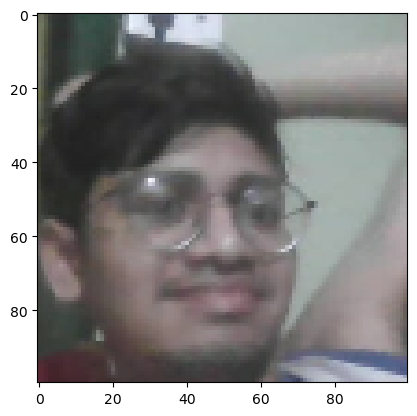

In [140]:
plt.imshow(img)

In [142]:
img.numpy().max() 

0.9870098

In [144]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [146]:
samples = data.as_numpy_iterator()

In [148]:
exampple = samples.next()

In [150]:
exampple

(b'data\\anchor\\bc95ef8b-3763-11ef-b857-902e16abf210.jpg',
 b'data\\positive\\2a2386fb-3764-11ef-8c1d-902e16abf210.jpg',
 1.0)

In [152]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [154]:
res = preprocess_twin(*exampple)

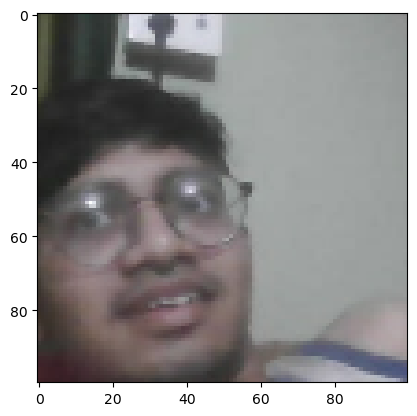

In [156]:
plt.imshow(res[1])

In [158]:
res[2]

1.0

In [160]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [162]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [164]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [166]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1, name='embedding')

# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Create embedding model
    embedding_model = make_embedding()

    # Obtain embeddings
    emb_input = embedding_model(input_image)
    emb_validation = embedding_model(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer([emb_input, emb_validation])

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Create the Siamese model
siamese_model = make_siamese_model()

# Print model summary
siamese_model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distance (L1Dist)             │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ distance[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [170]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [172]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [174]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [176]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [178]:
EPOCHS = 50

In [180]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 908ms/step

 Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 789ms/step

 Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step

 Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step

 Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 762ms/step

 Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 763ms/step

 Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step

 Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step

 Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step

 Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step

 Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 788ms/step

 Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step

 Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 763ms/step

 Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step

 Epoch 15/50
9/9 ━━━━━━━━━━━━━━━

In [182]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [184]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [186]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


array([[4.2534493e-06],
       [9.8642141e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [5.0630661e-05],
       [9.8501384e-01],
       [2.1028633e-05],
       [6.2250081e-08],
       [1.1225931e-06],
       [1.0000000e+00],
       [1.0344112e-08],
       [4.9474622e-08],
       [9.9999976e-01],
       [2.9617675e-05],
       [9.9999362e-01]], dtype=float32)

In [188]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]

In [190]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [225]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

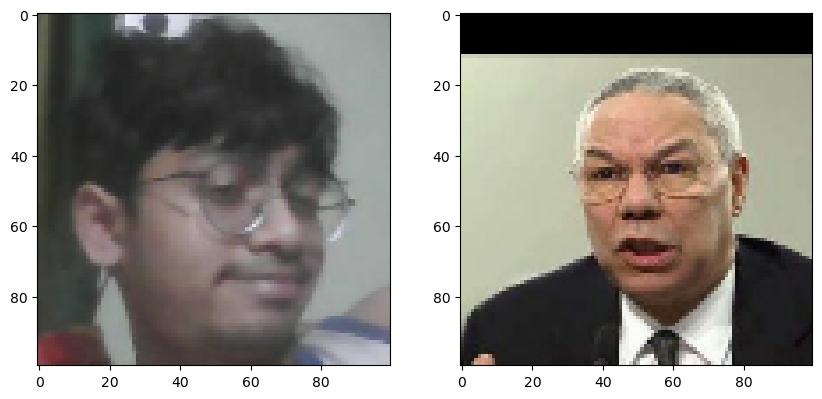

In [227]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])


# Renders cleanly
plt.show()

In [229]:
# Save weights using the native Keras format
siamese_model.save('siamesemodel.keras')


In [231]:
L1Dist

__main__.L1Dist

In [233]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [235]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


array([[4.2534493e-06],
       [9.8642141e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [5.0630661e-05],
       [9.8501384e-01],
       [2.1028633e-05],
       [6.2250081e-08],
       [1.1225931e-06],
       [1.0000000e+00],
       [1.0344112e-08],
       [4.9474622e-08],
       [9.9999976e-01],
       [2.9617675e-05],
       [9.9999362e-01]], dtype=float32)

In [237]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distance (L1Dist)             │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ distance[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [239]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0e7bcec4-375b-11ef-bf80-902e16abf210.jpg',
 '0f2f4829-375b-11ef-8329-902e16abf210.jpg',
 '1aa6ba4d-3764-11ef-8135-902e16abf210.jpg',
 '1c491f65-3764-11ef-9bb6-902e16abf210.jpg',
 '1e5947fe-3764-11ef-994d-902e16abf210.jpg',
 '1ec0d64c-3764-11ef-b439-902e16abf210.jpg',
 '1f510ee2-3764-11ef-a027-902e16abf210.jpg',
 '24af0567-3764-11ef-ae52-902e16abf210.jpg',
 '27e45c41-3763-11ef-a649-902e16abf210.jpg',
 '29e24519-375b-11ef-b6c1-902e16abf210.jpg',
 '2a2386fb-3764-11ef-8c1d-902e16abf210.jpg',
 '2b41c408-375b-11ef-8a1b-902e16abf210.jpg',
 '2b70d93f-3764-11ef-bfe7-902e16abf210.jpg',
 '2c24e3dc-3764-11ef-b25b-902e16abf210.jpg',
 '2c9d4a5f-3764-11ef-9777-902e16abf210.jpg',
 '2cdc3388-375b-11ef-a6be-902e16abf210.jpg',
 '2d799746-3764-11ef-b658-902e16abf210.jpg',
 '2dbe2f82-3764-11ef-a109-902e16abf210.jpg',
 '2e081e3c-3763-11ef-b411-902e16abf210.jpg',
 '2ebd4e00-3763-11ef-9fa2-902e16abf210.jpg',
 '30cc44d6-3764-11ef-81f9-902e16abf210.jpg',
 '31cf8b40-3764-11ef-baa4-902e16abf210.jpg',
 '31e13d05

In [241]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [243]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0e7bcec4-375b-11ef-bf80-902e16abf210.jpg
application_data\verification_images\0f2f4829-375b-11ef-8329-902e16abf210.jpg
application_data\verification_images\1aa6ba4d-3764-11ef-8135-902e16abf210.jpg
application_data\verification_images\1c491f65-3764-11ef-9bb6-902e16abf210.jpg
application_data\verification_images\1e5947fe-3764-11ef-994d-902e16abf210.jpg
application_data\verification_images\1ec0d64c-3764-11ef-b439-902e16abf210.jpg
application_data\verification_images\1f510ee2-3764-11ef-a027-902e16abf210.jpg
application_data\verification_images\24af0567-3764-11ef-ae52-902e16abf210.jpg
application_data\verification_images\27e45c41-3763-11ef-a649-902e16abf210.jpg
application_data\verification_images\29e24519-375b-11ef-b6c1-902e16abf210.jpg
application_data\verification_images\2a2386fb-3764-11ef-8c1d-902e16abf210.jpg
application_data\verification_images\2b41c408-375b-11ef-8a1b-902e16abf210.jpg
application_data\verification_images\2b70d93f-3764-11ef-bfe7-902

In [253]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [283]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.94, 0.94)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━